Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/TP1_CNN_denoising.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FTP1_CNN_denoising.ipynb&branch=main" target="_blank">Rosenblatt</a>

# TP 1.  Adaptation d'un réseau CNN pour le débruitage et l'inpainting

Dans ce TP, on va utiliser un réseau CNN basique pour tester sa capacité à effectuer du débruitage ou de l'inpainting.
<br>
<br>
<br>
## Imports des librairies et configuration

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
import matplotlib.pyplot as plt

# Configuration du device : CPU ('cpu') oou GPU ('cuda:0' ou cuda:1'). 
# Si on execute sur une machine sans GPU, les calculs seront plus lents.
# N.B. Le serveur Rosenblatt dispose de deux GPUs, on peut donc spécifier
# 'cuda:0' ou 'cuda:1' dans la ligne ci-dessous. Si beaucoup d'utilisateurs
# utilisent le même GPU en même temps, ça peut évidemment ralentir les calculs!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Dossier où sont téléchargées les données. Fonctionne sur le serveur Rosenblatt,
# sinon il faut spécifier un dossier local et y avoir placé les données qui ne sont
# directement téléchargeables avec Pytorch (en l'occurrence FER2013)
dataroot = '/home/jupyter-glaunes/data_M2MMAS/'

# Hyper paramètres

# nombre d'époques. On choisit 1 seule époque pour aller plus vite dans les premiers exemples
# qui sont simples. Ensuite plus bas on augmentera à 3 puis à 5. La bonne pratique serait de fixer 
# un nombre d'époques maximal grand (e.g. 100) et de faire de l'early stopping avec un test de
# validation.
num_epochs = 1

# taille des batchs et learning rate: on fixe des valeurs pour tous les essais mais on pourrait en tester d'autres.
batch_size = 16
learning_rate = 0.001

device: cuda:0


## Datasets d'images

In [24]:
# N.B. par rapport au notebook de départ, on encapsule la déclaration du dataset dans une fonction.
# Ceci permettra de refaire des tests plus loin avec des données, modèles ou paramètres différents
# sans avoir à recopier tout le code. On fera la même chose plus loin pour le code d'entraînement.

def get_dataset(dataset):
    if dataset == "MNIST":
        train_dataset = torchvision.datasets.MNIST(root=dataroot, train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        test_dataset = torchvision.datasets.MNIST(root=dataroot, train=False,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        n_channels = 1
    elif dataset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root=dataroot, train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        test_dataset = torchvision.datasets.CIFAR10(root=dataroot, train=False,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        n_channels = 3
    elif dataset == "FER2013":
        train_dataset = torchvision.datasets.FER2013(root=dataroot, split="train",
                                                     transform=transforms.ToTensor())
        test_dataset = torchvision.datasets.FER2013(root=dataroot, split="test",
                                                    transform=transforms.ToTensor())
        n_channels = 1
    elif dataset == "Imagenette":
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.RandomCrop(size=(20,32),pad_if_needed=True)])
        train_dataset = torchvision.datasets.Imagenette(root=dataroot, split="train",
                                                        transform=transform,
                                                        download=True)
        test_dataset = torchvision.datasets.Imagenette(root=dataroot, split="val",
                                                       transform=transform,
                                                       download=True)
        n_channels = 3
    
    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
    return train_dataset, train_loader, test_dataset, test_loader, n_channels

dataset = "MNIST"
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)

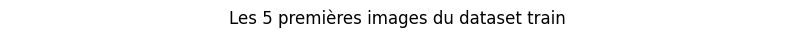

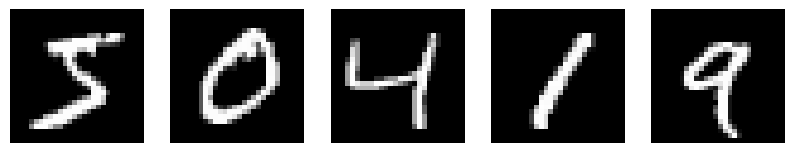

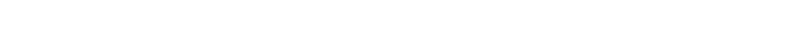

In [25]:
# affichage de quelques images
def show_images(images, nrows=1, title=None, width=10):
    nb_ims = images.shape[0]
    plt.figure(figsize=(width,0.1))
    plt.axis("off")
    plt.title(title)
    plt.show()
    ncols = math.ceil(nb_ims/nrows)
    plt.figure(figsize=(width,width/ncols))
    for k in range(nb_ims):
       plt.subplot(nrows, ncols, k+1)
       plt.imshow(images[k].permute((1,2,0)), cmap="gray")
       plt.axis("off")
    plt.show()
    plt.figure(figsize=(width,0.3))
    plt.axis("off")
    plt.show()

def load_batch(dataset, n):
  return torch.stack([dataset[k][0] for k in range(n)])

train_images_sample = load_batch(train_dataset, 5)
show_images(train_images_sample, title="Les 5 premières images du dataset train")

## Fonctions pour simuler la dégradation des images

In [26]:
# bruit gaussien
def gaussian_noise(images,sigma=.1):
    res = images + torch.randn(images.shape, device=images.device)*sigma
    res = res.clip(0,1)
    return res

# bruit "Salt and Pepper"
def salt_and_pepper(images,prob=.1):
    images_noisy = images.clone().permute((0,2,3,1))
    rnd = torch.rand(images_noisy.shape[:-1])
    images_noisy[rnd<prob/2,:] = 0
    images_noisy[rnd>1-prob/2,:] = 1
    return images_noisy.permute((0,3,1,2))

# suppression d'un bloc de pixel (pour l'inpainting)
def random_remove(images, size=(16,16)):
    images_out = images.clone().permute((0,2,3,1))
    i = torch.randint(images_out.shape[1]-size[0], (images_out.shape[0],))
    j = torch.randint(images_out.shape[2]-size[0], (images_out.shape[0],))
    for k in range(images_out.shape[0]):
        images_out[k,i[k]:(i[k]+size[0]),j[k]:(j[k]+size[1]),:] = 0
    return images_out.permute((0,3,1,2))

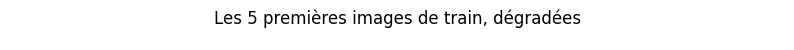

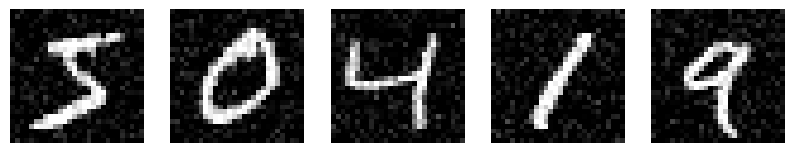

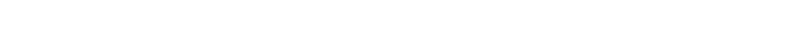

In [27]:
# On va d'abord tester avec un bruit gaussien faible

corrupt_fun = gaussian_noise

train_images_sample_noisy = corrupt_fun(train_images_sample)
show_images(train_images_sample_noisy, title="Les 5 premières images de train, dégradées")

## Définition du réseau

__Question 1__. En vous basant sur le modèle du notebook de classification du dataset MNIST, définir un réseau CNN simple permetant d'effectuer une tache de débruitage. La modification essentielle à apporter est que la sortie du réseau doit être de la même taille que l'entrée, puisqu'ici les labels de la tache de classification sont remplacés par les images débruitées. D'autre part, on veut que le réseau puisse fonctionner avec un nombre de canaux d'entrée quelconque (argument `n_channels` en entrée) pour pouvoir traiter à la fois les images en niveaux de gris et en couleurs.

In [28]:
# On définit une classe pour le réseau CNN

class ConvNet(nn.Module):
    def __init__(self, n_channels):
        super(ConvNet, self).__init__()
        # entrée = (h,w,n_channels)
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        # (h,w,16)
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU())
        # (h,w,32)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, n_channels, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [29]:
# On crée une instance du réseau
model = ConvNet(n_channels).to(device)

## Fonction de perte et optimiseur

Ici la fonction de perte (loss function) est différente, puisqu'on ne compare plus des classes mais des images. On peut utiliser le critère des moindres carrés : Mean Square Error (MSE) loss.

In [30]:
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Entraînement du réseau.

In [31]:
# On écrit une fonction pour l'entraînement du réseau

def train_network(train_loader, corrupt_fun, model, lossfun, 
                  optimizer, num_epochs, print_progress=True, plot_loss=True):
    print("beginning training...")
    total_step = len(train_loader)
    rec_loss = np.zeros((num_epochs,len(train_loader)))
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)
            images_noisy = corrupt_fun(images)
    
            # Forward pass
            outputs = model(images_noisy)
            loss = lossfun(outputs,images)
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            rec_loss[epoch,i] = loss.item()

            if print_progress and ((i+1) % 100 == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print("training done")
    if plot_loss:
        plt.figure(figsize=(8,4))
        plt.plot(rec_loss.flatten())
        plt.title("loss vs iterations")
    return model, rec_loss

beginning training...
Epoch [1/1], Step [100/3750], Loss: 0.0019
Epoch [1/1], Step [200/3750], Loss: 0.0015
Epoch [1/1], Step [300/3750], Loss: 0.0014
Epoch [1/1], Step [400/3750], Loss: 0.0014
Epoch [1/1], Step [500/3750], Loss: 0.0014
Epoch [1/1], Step [600/3750], Loss: 0.0013
Epoch [1/1], Step [700/3750], Loss: 0.0026
Epoch [1/1], Step [800/3750], Loss: 0.0011
Epoch [1/1], Step [900/3750], Loss: 0.0018
Epoch [1/1], Step [1000/3750], Loss: 0.0012
Epoch [1/1], Step [1100/3750], Loss: 0.0011
Epoch [1/1], Step [1200/3750], Loss: 0.0011
Epoch [1/1], Step [1300/3750], Loss: 0.0010
Epoch [1/1], Step [1400/3750], Loss: 0.0012
Epoch [1/1], Step [1500/3750], Loss: 0.0012
Epoch [1/1], Step [1600/3750], Loss: 0.0011
Epoch [1/1], Step [1700/3750], Loss: 0.0013
Epoch [1/1], Step [1800/3750], Loss: 0.0011
Epoch [1/1], Step [1900/3750], Loss: 0.0010
Epoch [1/1], Step [2000/3750], Loss: 0.0012
Epoch [1/1], Step [2100/3750], Loss: 0.0011
Epoch [1/1], Step [2200/3750], Loss: 0.0009
Epoch [1/1], Step [

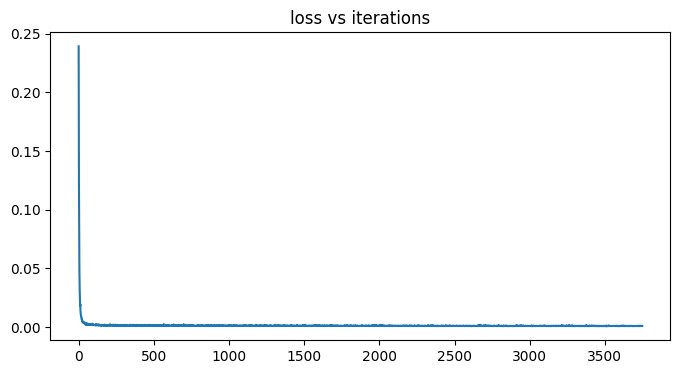

In [32]:
# On lance l'entraînement:
model, rec_loss = train_network(train_loader, corrupt_fun, model, lossfun, optimizer, num_epochs)

<br>
<br>
<br>
On affiche la sortie du réseau pour cinq images test. Ces sorties sont censées être des images très proches des images initiales car le réseau a été entraîné pour ça.

In [33]:
# On définit une fonction pour le test (on s'en servira plusieurs fois):

def test_model(model, test_dataset, corrupt_fun):
    test_images_sample = load_batch(test_dataset, 5)
    test_images_sample_corrupt = corrupt_fun(test_images_sample)
    
    outputs = model(test_images_sample_corrupt.to(device)).detach().cpu()
    
    show_images(test_images_sample_corrupt, title="Les 5 premières images test, dégradées (entrée du réseau)")
    show_images(outputs, title="sorties du réseau")
    show_images(test_images_sample, title="Les 5 premières images test")

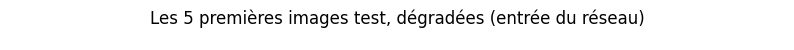

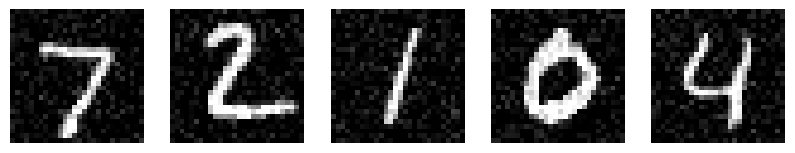

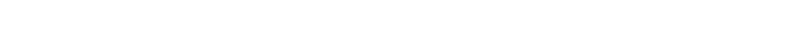

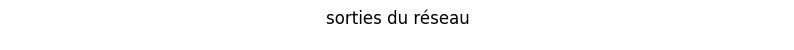

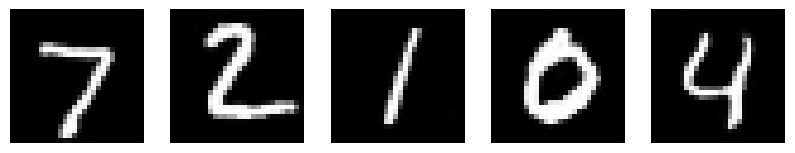

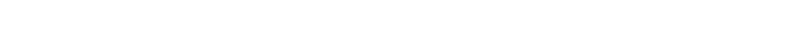

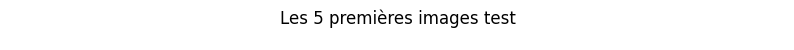

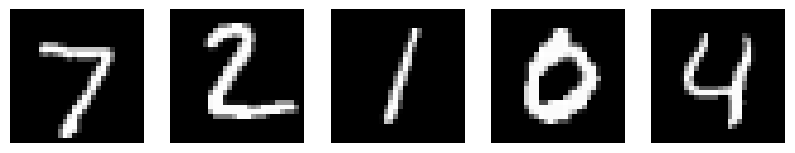

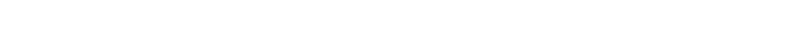

In [34]:
test_model(model, test_dataset, corrupt_fun)

__Question 2.__ Tester le réseau avec des niveaux de bruits différents, pour le bruit gaussien et le bruit salt-and-pepper. Tester également le réseau pour la tache d'inpainting (fonction `random_remove`)

beginning training...
training done


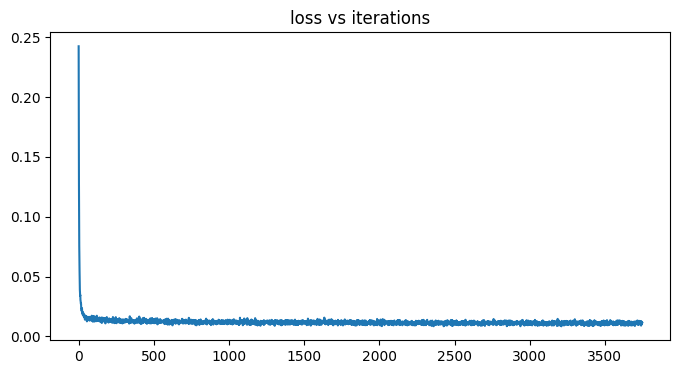

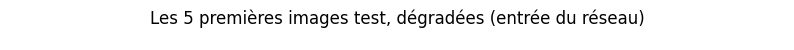

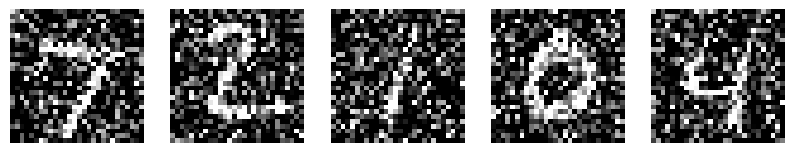

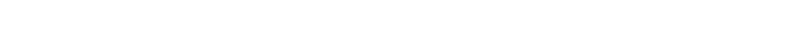

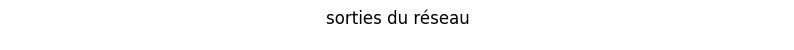

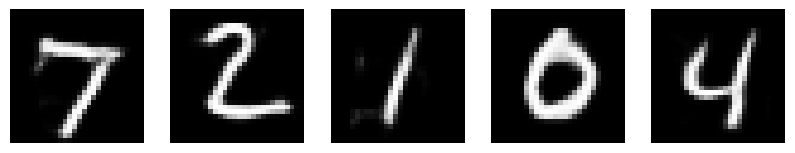

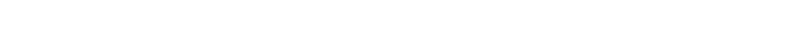

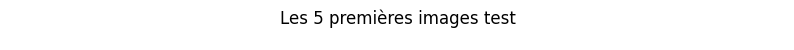

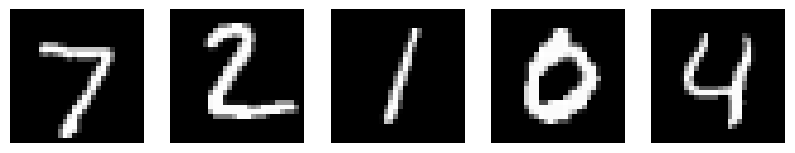

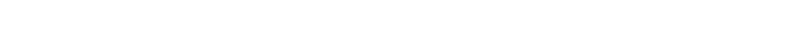

In [35]:
# 1) Test avec bruit gaussien élevé:
corrupt_fun = lambda x : gaussian_noise(x,sigma=.5)
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

beginning training...
training done


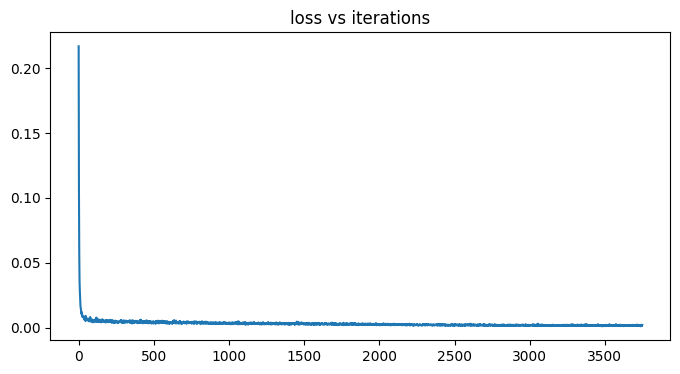

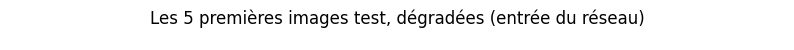

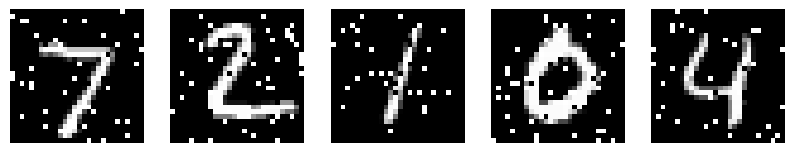

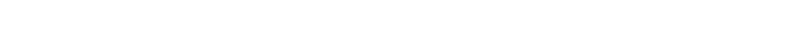

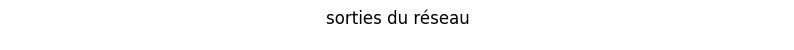

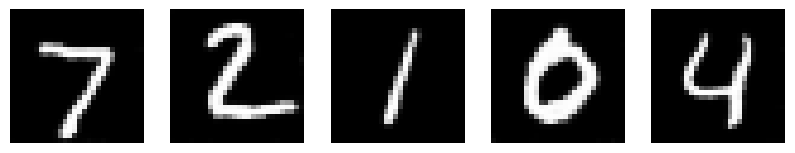

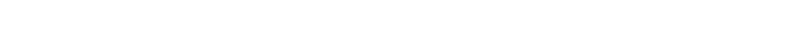

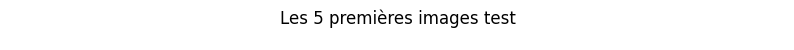

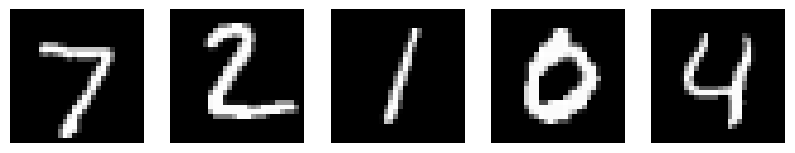

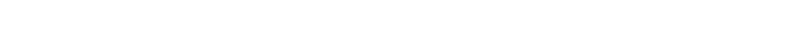

In [36]:
# 2) Test avec bruit salt-and-pepper faible:
corrupt_fun = salt_and_pepper
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

beginning training...
training done


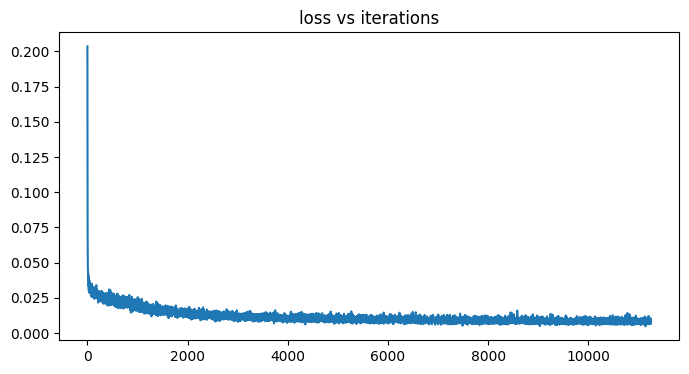

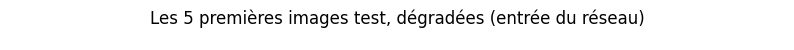

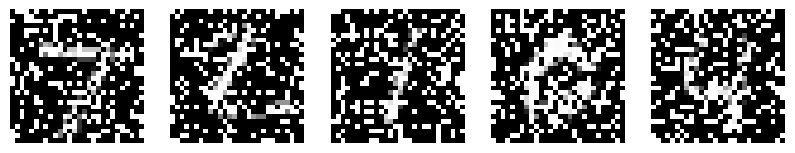

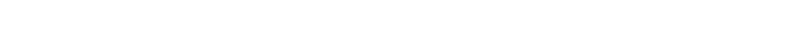

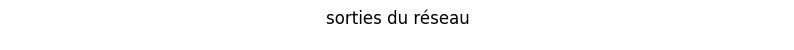

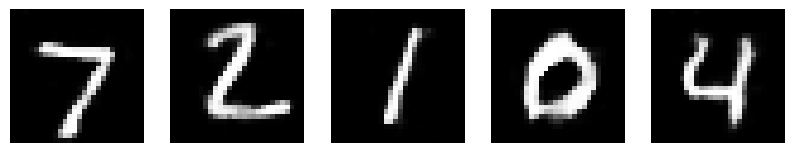

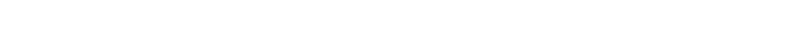

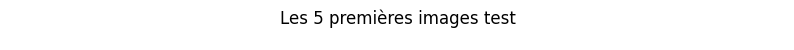

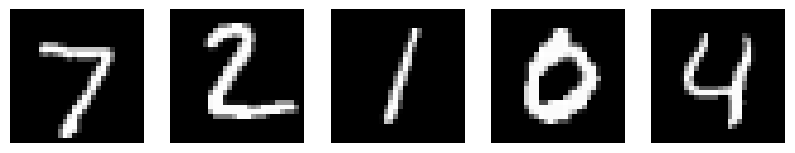

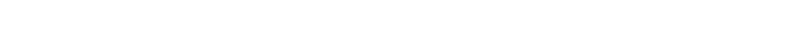

In [37]:
# 3) Test avec bruit salt-and-pepper fort:
corrupt_fun = lambda x : salt_and_pepper(x,prob=.5)
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 3
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

On constate que pour du débruitage, avec les données MNIST, même pour un niveau de bruit élevé, le réseau débruite très bien. 

_Remarque_ : on peut tester si le réseau est capable de débruiter une image avec bruit gaussien s'il a été entraîné pour du bruit d'un autre type:

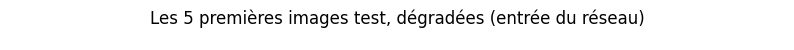

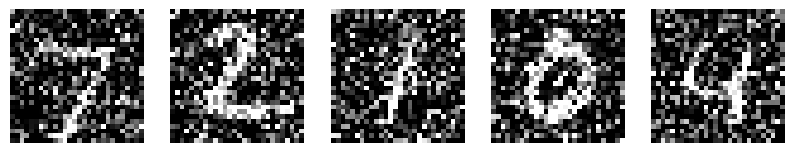

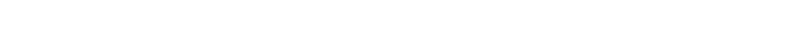

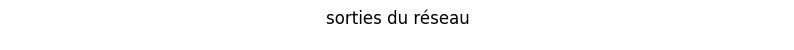

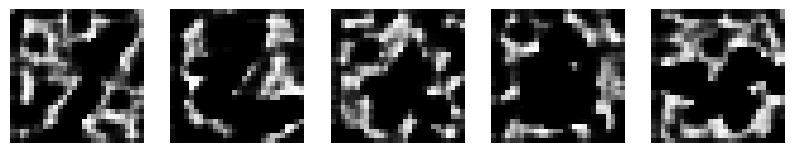

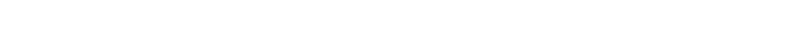

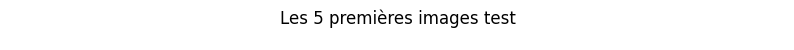

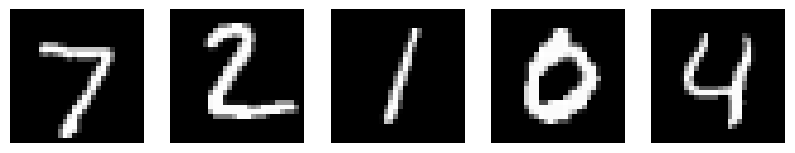

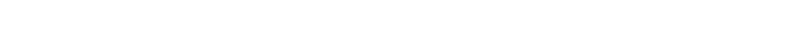

In [38]:
corrupt_fun = lambda x : gaussian_noise(x, sigma=.5)
test_model(model, test_dataset, corrupt_fun)

On constate que ça marche beaucoup moins bien que s'il avait été entraîné pour du bruit gaussien. Le réseau est uniquement adapté au type de dégradation avec lequel il a été entraîné.

On peut du coup essayer de voir s'il est possible d'entraîner le même réseau pour deux types de dégradation différents en même temps. Pour cela on peut définir une dégradation mixte qui ajoute aléatoirement un des deux types de bruits, puis entraîner avec.

beginning training...
training done


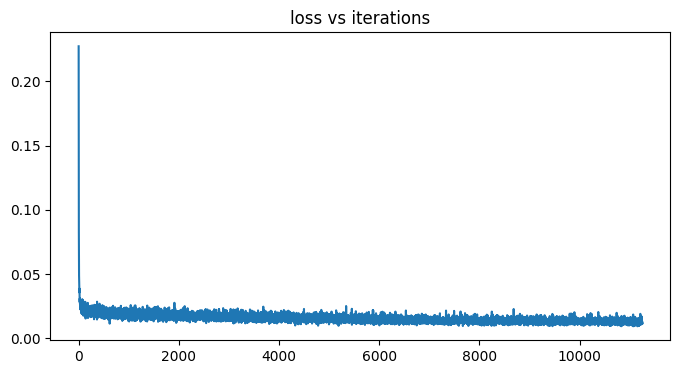

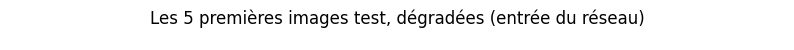

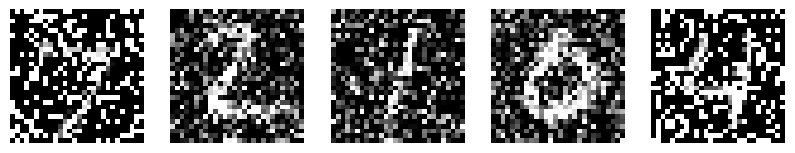

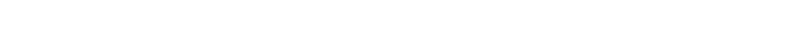

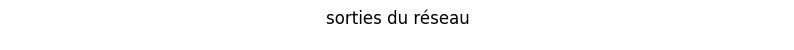

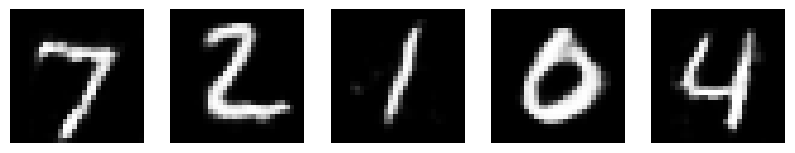

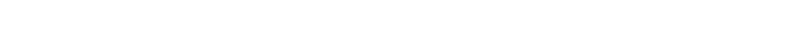

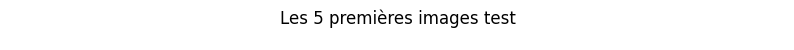

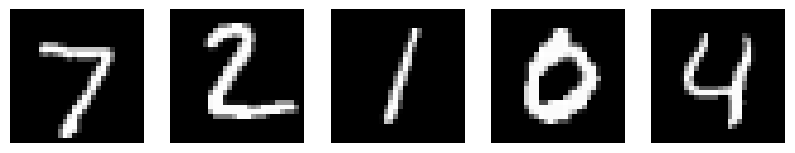

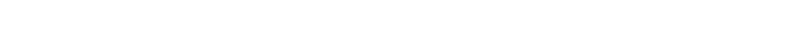

In [39]:
def bruit_mixte(images):
    batch_size = images.shape[0]
    ind = torch.rand(batch_size)<.5
    out = images.clone()
    out[ind,...] = gaussian_noise(out[ind,...],sigma=.5)
    out[~ind,...] = salt_and_pepper(out[~ind,...],prob=.5)
    return out
    
corrupt_fun = bruit_mixte
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

beginning training...
training done


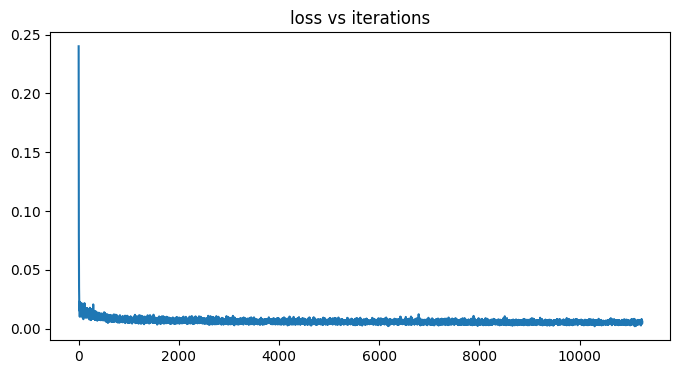

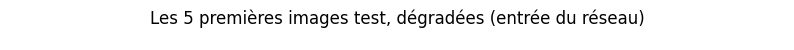

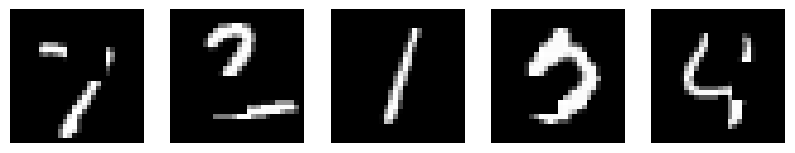

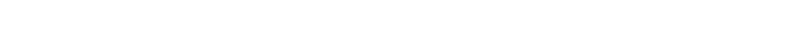

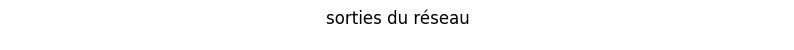

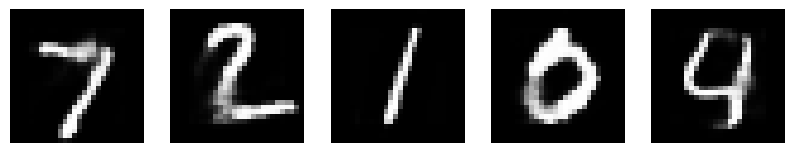

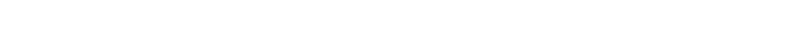

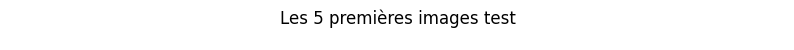

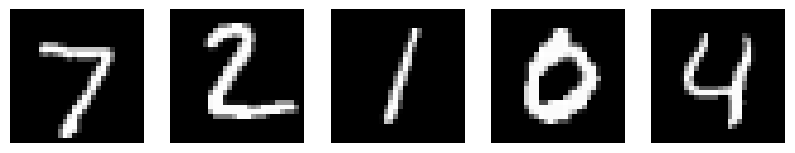

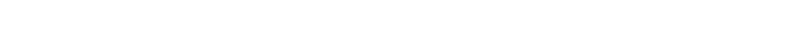

In [40]:
# 4) Test d'inpainting avec suppression de petit bloc:
corrupt_fun = lambda x : random_remove(x,size=(8,8))
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

beginning training...
training done


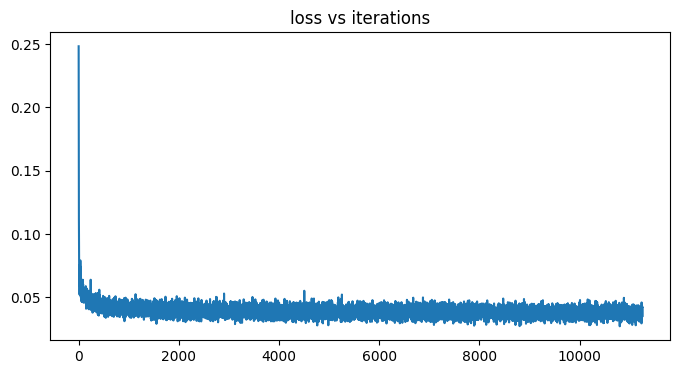

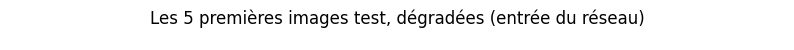

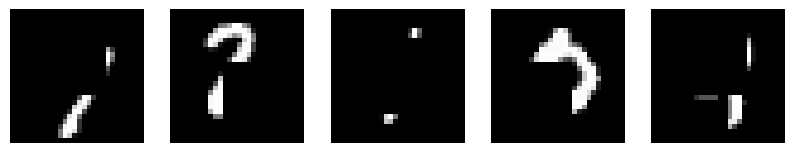

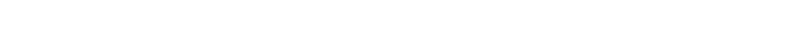

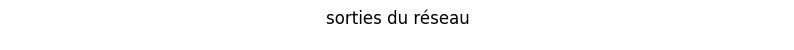

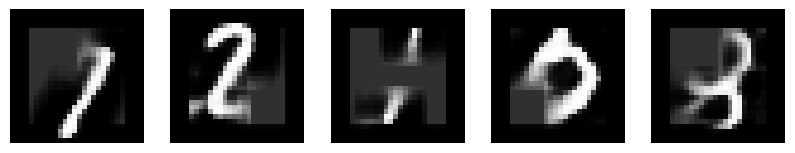

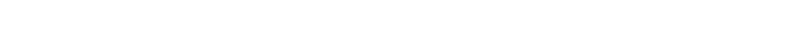

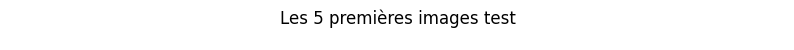

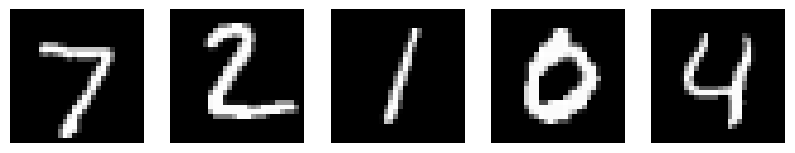

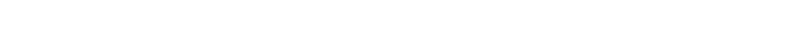

In [41]:
# 5) Test d'inpainting avec suppression de gros bloc:
corrupt_fun = lambda x : random_remove(x,size=(16,16))
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

Pour l'inpainting, à la différence du denoising, le réseau a plus de difficultés à restaures les images. Pour une dégradation faible la performance est assez bonne, mais pour des blocs plus grands, il parvient à retaurer un peu l'image seulement localement et pas au centre de la zone supprimée. C'est sans doute à cause du problème du "champ réceptif" insuffisant: avec seulement 3 couches et des filtres de taille 5, un pixel ne peut pas influencer un neurone situé à une distance supérieure à 9 pixels, ce qui est insuffisant. Une solution sera d'augmenter le nombre de couches (ou d'augmenter la taille des filtres, mais de manière générale l'expérience montre que l'utilisation de filtres de grande taille n'est pas efficace pour les CNNs, la tendance est plutôt de choisir des filtres (3,3)).

<br>
<br>
<br>

__Question 3.__ Tester également avec les différents datasets disponibles, pour des niveaux de bruits assez élevés. Que peut-on remarquer ?

beginning training...
training done


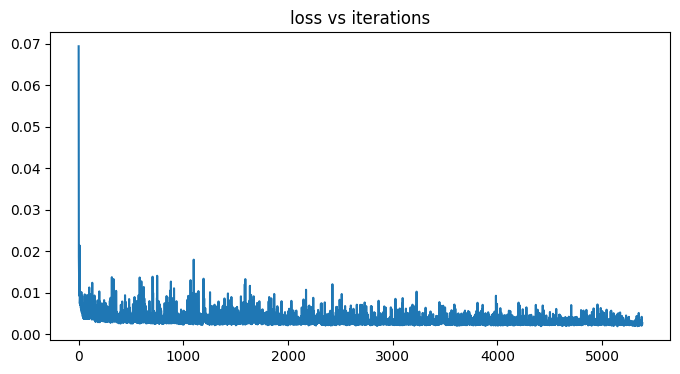

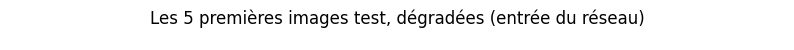

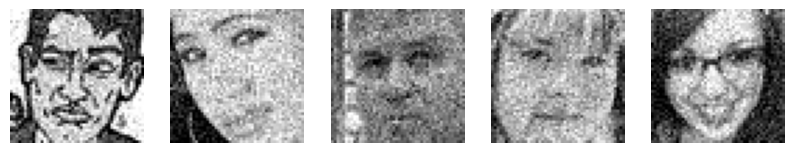

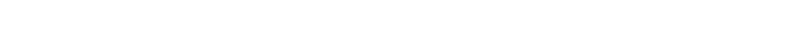

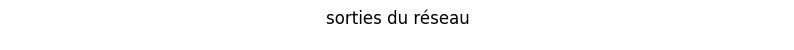

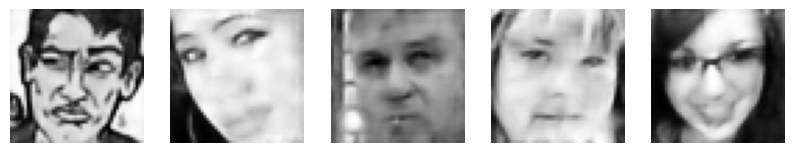

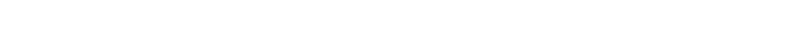

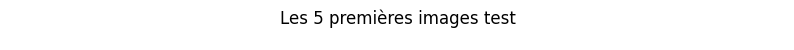

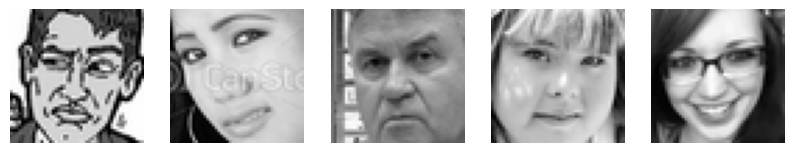

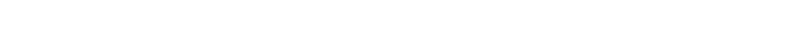

In [42]:
# Données FER2013:
dataset = "FER2013" 
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)

# Test avec bruit gaussien faible:
corrupt_fun = lambda x : gaussian_noise(x,sigma=.1)
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

beginning training...
training done


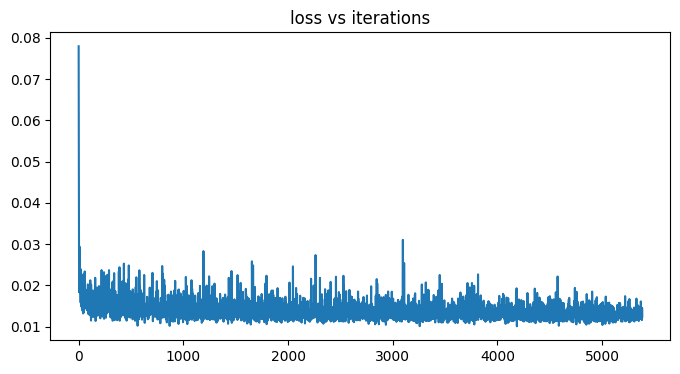

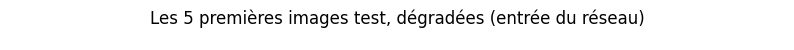

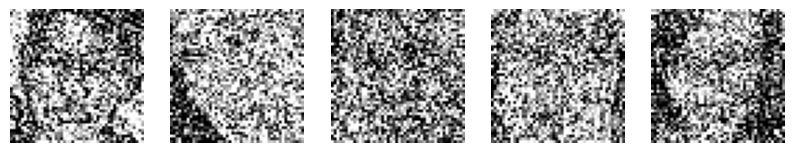

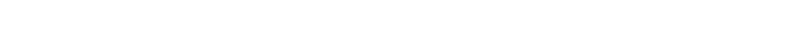

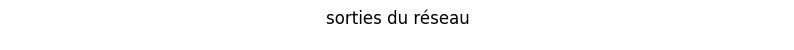

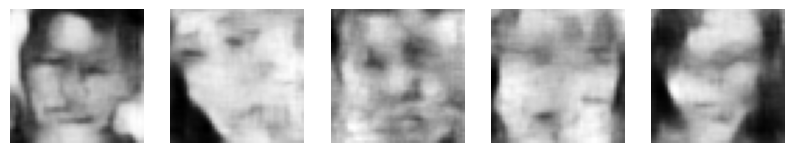

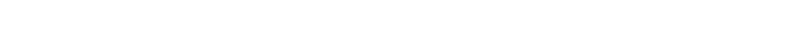

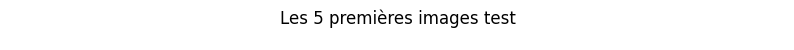

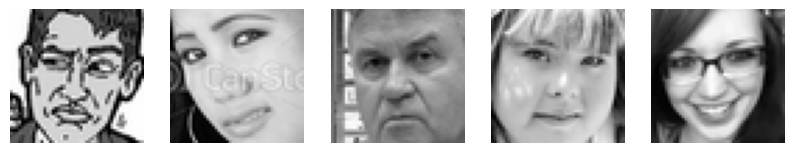

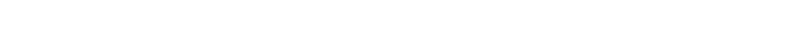

In [43]:
# Test avec bruit gaussien fort:
corrupt_fun = lambda x : gaussian_noise(x,sigma=.5)
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

beginning training...
training done


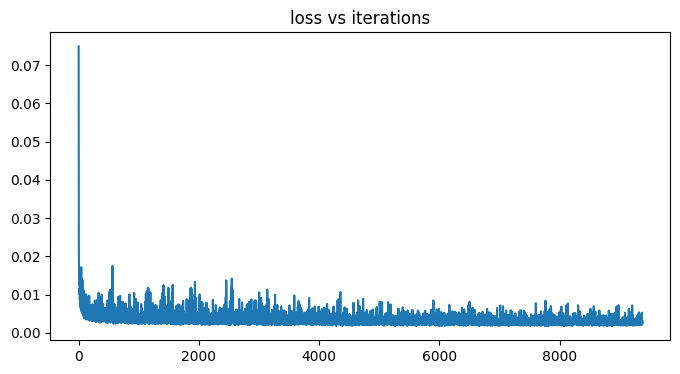

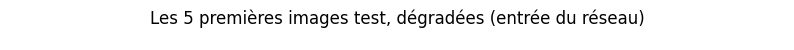

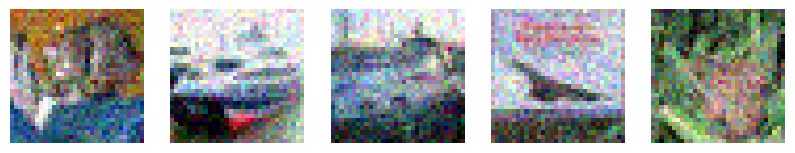

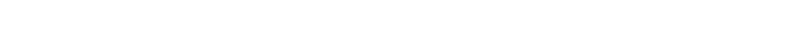

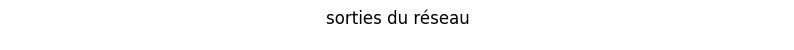

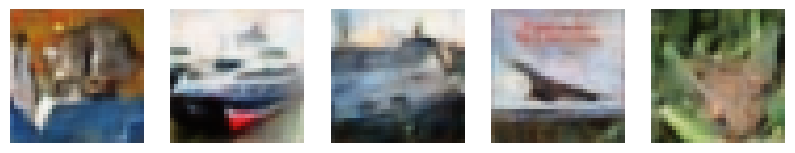

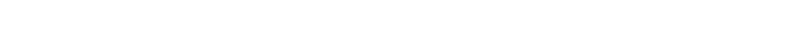

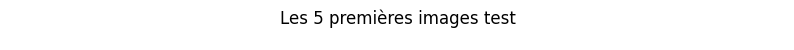

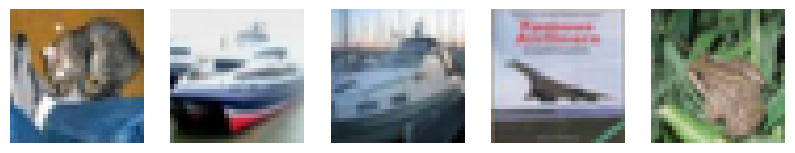

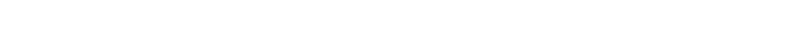

In [44]:
# Données CIFAR:
dataset = "CIFAR10" 
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)

# Test avec bruit gaussien faible:
corrupt_fun = lambda x : gaussian_noise(x,sigma=.1)
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

On constate que pour les datasets FER2013 et CIFAR10, les reconstructions sont nettement moins bonnes. Les images reconstruites sont assez floues. La différence principale avec MNIST est que la variabilité des images (visages pour FER2013, images quelconques pour CIFAR) est beaucoup plus importante, et le dataset n'est probablement pas assez grand pour représenter la distribution des images (i.e. la distribution empirique des images n'est pas assez proche de la distribution limite car le nombre d'images $n$ dans le dataset n'est pas assez grand en regard de la complexité de la distribution). De plus le réseau qu'on a codé n'a sans doute pas assez d'expressivité. On pourrait donc penser ici à augmenter la profondeur ou le nombre de canaux, même si ça ne suffira probablement pas. Une autre raison est qu'on a construit ici un réseau CNN basique, qui n'est pas spécifiquement performant pour du débruitage. On verra plus tard qu'il existe des réseaux dédiés pour ce type de tache.

<br>
<br>
<br>

__Question 4.__ Modifier la définition du réseau afin qu'il puisse avoir un nombre de couches quelconque, fourni en entrée (`def __init__(self, n_channels, n_layers):`), en choisissant une configuration cohérente pour les dimensions des couches internes.

In [45]:
# Réseau CNN
class ConvNet(nn.Module):
    def __init__(self, n_channels, n_layers):
        super(ConvNet, self).__init__()
        # entrée = (h,w,n_channels)
        self.layer_input = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU()) # (h,w,16)
        # (h,w,16)
        self.layer_intern = []
        for i in range(n_layers-2):
            layer = nn.Sequential(
                nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(16),
                nn.ReLU())
            self.layer_intern.append(layer)
        # La commande suivante est nécessaire pour "enregistrer" la liste des couches
        # qu'on vient de définir comme une partie du réseau, sinon PyTorch ne saura pas
        # que les paramètres de ces couches sont à optimiser.
        self.layer_intern = nn.ModuleList(self.layer_intern)
        # (h,w,16)
        self.layer_output = nn.Sequential(
            nn.Conv2d(16, n_channels, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer_input(x)
        for i in range(len(self.layer_intern)):
            out = self.layer_intern[i](out)
        out = self.layer_output(out)
        return out

__Question 5.__ Tester le bénéfice obtenu en augmentant la profondeur du réseau, sur les taches les plus difficiles.

beginning training...
training done


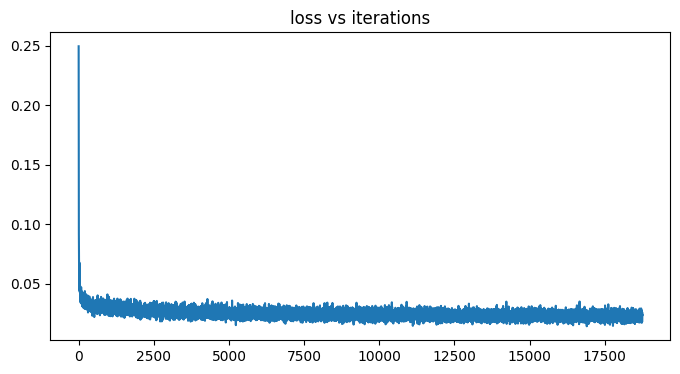

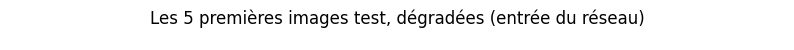

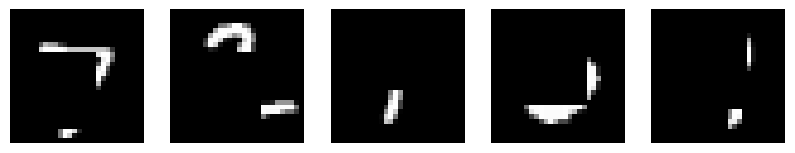

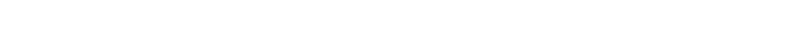

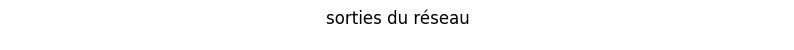

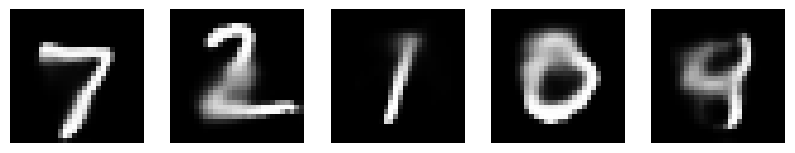

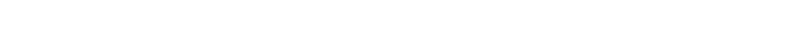

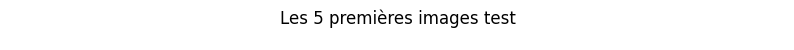

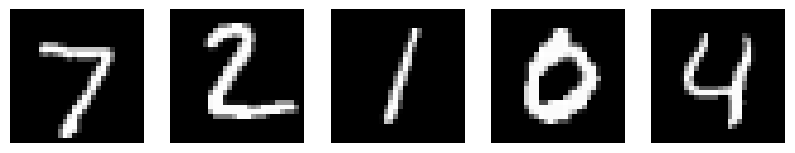

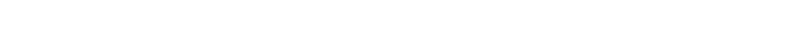

In [46]:
# On teste un modèle à 10 couches sur MNIST pour l'inpainting avec gros blocs
dataset = "MNIST" 
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)
corrupt_fun = lambda x : random_remove(x,size=(16,16))
model = ConvNet(n_channels,10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 5
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

On constate que pour cette tache d'inpainting, on a résolu le problème de champ réceptif, mais les reconstructions ne sont pas toujours très satisfaisantes, il y a un effet de flou. En fait le réseau estime l'espérance de l'image moyennée conditionnellement à l'entrée, au lieu d'estimer l'image la plus vraisemblable. 

beginning training...
training done


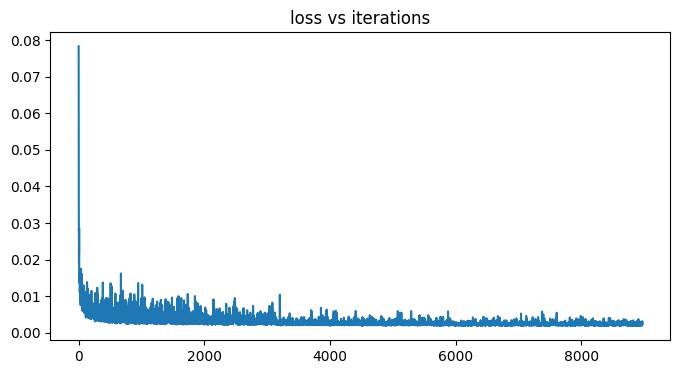

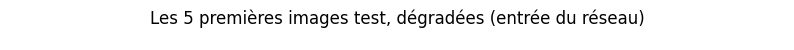

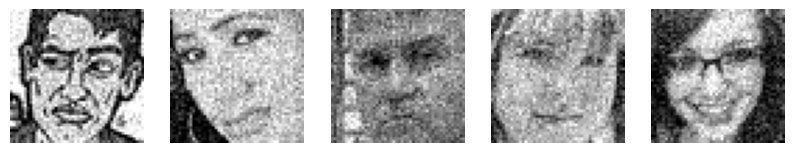

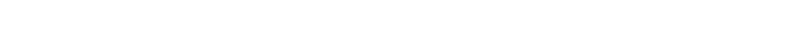

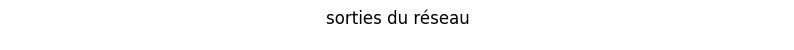

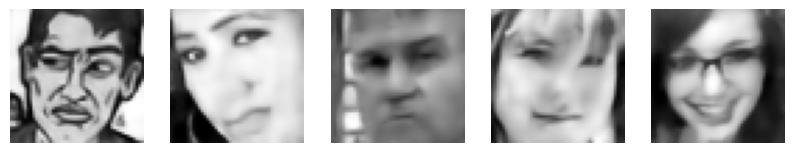

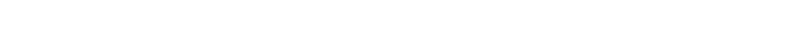

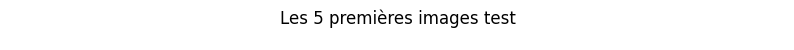

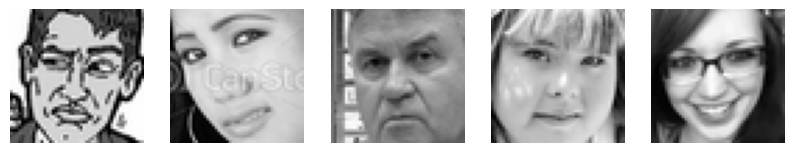

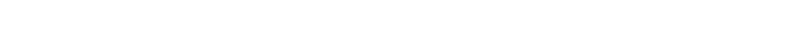

In [47]:
# On teste un modèle à 10 couches sur FER2013 pour le denoising
dataset = "FER2013" 
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)
corrupt_fun = lambda x : gaussian_noise(x,.1)
model = ConvNet(n_channels,10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model, 
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

On constate là aussi que les images reconstruites sont assez floues, on n'a pas vraiment amélioré en augmentant la profondeur du réseau. Le dataset n'est pas suffisamment grand pour représenter toute la distribution des images de visages.